In [1]:
from scipy.sparse import coo_matrix
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [2]:
animes_data_path = "preprocessed_animes.csv"
profiles_data_path = "preprocessed_profiles.csv"
reviews_data_path = "preprocessed_reviews.csv"
animes_data = pd.read_csv(animes_data_path)
profiles_data = pd.read_csv(profiles_data_path)
reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)

animes = animes_data.copy()
profiles = profiles_data.copy()
reviews = reviews_data.copy()

<ipython-input-2-7df933736d05>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)


In [3]:
np.random.seed(0)
unique_AnimeID = reviews['anime_uid'].unique()
unique_users = reviews['profile'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_users:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_AnimeID:
    movie_old2new_id_dict[i] = j
    j += 1

In [4]:
user_list = reviews['profile'].values
movie_list = reviews['anime_uid'].values
for j in range(len(reviews)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
reviews['profile'] = user_list
reviews['anime_uid'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(reviews)) <= 0.7
train_df = reviews[train_index]
test_df = reviews[~train_index]

# generate train_mat and test_mat
num_user = len(reviews['profile'].unique())
num_items = len(reviews['anime_uid'].unique())

train_mat = coo_matrix((train_df['score'].values, (train_df['profile'].values, train_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()
test_mat = coo_matrix((test_df['score'].values, (test_df['profile'].values, test_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()

In [5]:
latent_factors = 30

P = np.random.rand(num_user, latent_factors)
Q = np.random.rand(latent_factors, num_items)

a = 0.01
b = 0.1
train_loss = []
test_loss = []
nonzero_indices_train = np.nonzero(train_mat)
nonzero_indices_test = np.nonzero(test_mat)

num_epochs = 6
for epoch in range(num_epochs):
    for i in range(num_user):
        for j in range(num_items):
            if train_mat[i, j] > 0:
                diff = train_mat[i, j] - np.dot(P[i, :], Q[:, j])
                P[i, :] += a * (diff * Q[:, j] - b * P[i, :])
                Q[:, j] += a * (diff * P[i, :] - b * Q[:, j])

    predicted_matrix = np.dot(P, Q)
    
    rmse_train = np.sqrt(np.mean((predicted_matrix[nonzero_indices_train] - train_mat[nonzero_indices_train])**2))
    rmse_test = np.sqrt(np.mean((predicted_matrix[nonzero_indices_test] - test_mat[nonzero_indices_test])**2))

    train_loss.append(rmse_train)
    test_loss.append(rmse_test)

    print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
    print('RMSE Train Loss: {:.4f}'.format(rmse_train), end=', ')
    print('RMSE Test Loss: {:.4f}'.format(rmse_test))

Epoch 1 of 6: RMSE Train Loss: 1.7963, RMSE Test Loss: 2.0552
Epoch 2 of 6: RMSE Train Loss: 1.5772, RMSE Test Loss: 1.9703
Epoch 3 of 6: RMSE Train Loss: 1.4526, RMSE Test Loss: 1.9418
Epoch 4 of 6: RMSE Train Loss: 1.3615, RMSE Test Loss: 1.9306
Epoch 5 of 6: RMSE Train Loss: 1.2864, RMSE Test Loss: 1.9272
Epoch 6 of 6: RMSE Train Loss: 1.2200, RMSE Test Loss: 1.9278


In [6]:
indices_train = np.argwhere(train_mat > 0)
train_df = {'user_id': [], 'item_id': [], 'rating': []}
for index in indices_train:
  train_df['user_id'].append(index[0])
  train_df['item_id'].append(index[1])
  train_df['rating'].append(train_mat[index[0], index[1]])

indices_test = np.argwhere(test_mat > 0)
test_df = {'user_id': [], 'item_id': [], 'rating': []}
for index in indices_test:
  test_df['user_id'].append(index[0])
  test_df['item_id'].append(index[1])
  test_df['rating'].append(test_mat[index[0], index[1]])

In [7]:
train_df = pd.DataFrame(train_df)
print(train_df.head())

test_df = pd.DataFrame(test_df)
print(test_df.head())

   user_id  item_id  rating
0        0        0     8.0
1        0       69     6.0
2        0      106     7.0
3        0      119     8.0
4        0      167     7.0
   user_id  item_id  rating
0        0        1     8.0
1        0       94     6.0
2        0      147     9.0
3        0      196     7.0
4        0      237     7.0


In [8]:
from torch.utils.data import DataLoader, TensorDataset
train_user_ids = torch.LongTensor(train_df['user_id'].values)
train_item_ids = torch.LongTensor(train_df['item_id'].values)
train_ratings = torch.FloatTensor(train_df['rating'].values)

train_dataset = TensorDataset(train_user_ids, train_item_ids, train_ratings)
batch_size = 256

# Create a DataLoader that generates batches of data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_user_ids = torch.LongTensor(test_df['user_id'].values)
test_item_ids = torch.LongTensor(test_df['item_id'].values)
test_ratings = torch.FloatTensor(test_df['rating'].values)

test_dataset = TensorDataset(test_user_ids, test_item_ids, test_ratings)

# Create a DataLoader that generates batches of data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim, pretrained_user_embs, pretrained_item_embs):
        super(NCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # User and item embeddings
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        
        self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

        if pretrained_user_embs is not None:
            self.user_embed.weight.data.copy_(torch.from_numpy(pretrained_user_embs))
        if pretrained_item_embs is not None:
            self.item_embed.weight.data.copy_(torch.from_numpy(pretrained_item_embs))

        
    def forward(self, user, item):
        # Embedding lookup
        user_embed = self.user_embed(user)
        item_embed = self.item_embed(item)
        
        # Concatenate the user and item embeddings
        x = torch.cat([user_embed, item_embed], dim=1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # Apply sigmoid function to output
        x = torch.sigmoid(x) * 10
        
        return x.squeeze()


In [48]:
# Define the model, loss function, and optimizer
embedding_dim = 30
hidden_dim = 5
model = NCF(num_user, num_items, embedding_dim, hidden_dim, P, Q.T)
loss_fn = nn.MSELoss()
lr = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 30
# Training loop
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = []
    for batch in train_dataloader:
        # Unpack the batch
        user, item, rating = batch
        
        # Forward pass
        rating_pred = model(user, item)
        loss = loss_fn(rating_pred, rating)
        running_train_loss.append(np.sqrt(loss.item()))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
    model.eval()
    running_test_loss = []

    with torch.no_grad():
      for batch in test_dataloader:
        user, item, rating = batch
        rating_pred = model(user, item)
        loss = loss_fn(rating_pred, rating)
        running_test_loss.append(np.sqrt(loss.item()))
    
    print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
    print('RMSE Train Loss: {:.4f}'.format(np.mean(running_train_loss)), end=', ')
    print('RMSE Test Loss: {:.4f}'.format(np.mean(running_test_loss)))

    train_loss.append(np.mean(running_train_loss))
    test_loss.append(np.mean(running_test_loss))

Epoch 1 of 30: RMSE Train Loss: 2.5997, RMSE Test Loss: 2.3430
Epoch 2 of 30: RMSE Train Loss: 2.1696, RMSE Test Loss: 2.1463
Epoch 3 of 30: RMSE Train Loss: 2.0871, RMSE Test Loss: 2.1236
Epoch 4 of 30: RMSE Train Loss: 2.0538, RMSE Test Loss: 2.0992
Epoch 5 of 30: RMSE Train Loss: 2.0131, RMSE Test Loss: 2.0647
Epoch 6 of 30: RMSE Train Loss: 1.9584, RMSE Test Loss: 2.0191
Epoch 7 of 30: RMSE Train Loss: 1.8893, RMSE Test Loss: 1.9717
Epoch 8 of 30: RMSE Train Loss: 1.8139, RMSE Test Loss: 1.9300
Epoch 9 of 30: RMSE Train Loss: 1.7477, RMSE Test Loss: 1.9043
Epoch 10 of 30: RMSE Train Loss: 1.6958, RMSE Test Loss: 1.8868
Epoch 11 of 30: RMSE Train Loss: 1.6550, RMSE Test Loss: 1.8749
Epoch 12 of 30: RMSE Train Loss: 1.6220, RMSE Test Loss: 1.8683
Epoch 13 of 30: RMSE Train Loss: 1.5928, RMSE Test Loss: 1.8608
Epoch 14 of 30: RMSE Train Loss: 1.5692, RMSE Test Loss: 1.8592
Epoch 15 of 30: RMSE Train Loss: 1.5498, RMSE Test Loss: 1.8565
Epoch 16 of 30: RMSE Train Loss: 1.5317, RMSE Tes

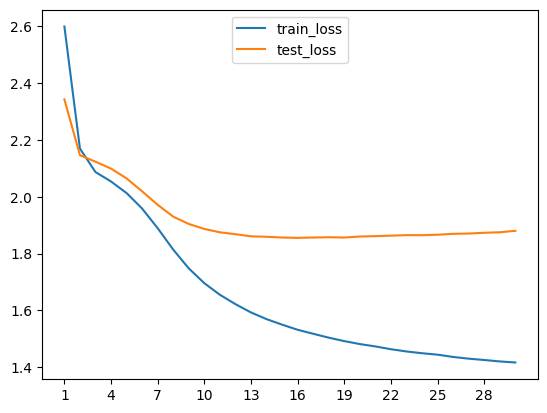

In [49]:
import matplotlib.pyplot as plt
x = [i + 1 for i in range(num_epochs)]
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, test_loss, label='test_loss')
leg = plt.legend(loc='upper center')
plt.xticks([i + 1 for i in range(0, num_epochs, 3)]) 
plt.show()